In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

*Updated 8/20/2021*
### Recall vs applied read depth filter

#### Input

CSV generated by testing pipeline of all true and false calls from all variant callers:
- DeepVariant (latest?)
- DiscoSNP (2.2.10)
- Freebayes (1.3.5)
- GATK (4.0.8.1)
- Lancet (1.1.0)
- VarDict-Java (1.8.2) 
- bcftools (1.13)

Columns from VCF: CHROM, POS, REF, ALT, QUAL, AD (split into AD_REF and AD_ALT), DP, GT (when calls are missed i.e., false negatives, GT value comes from the variants.py mutation list, which is set to 1 by default), RK_DISCOSNP (from INFO/Rk)

Added columns:
- TYPE: from variants.py (options are SNP, INS, DEL only) or from VCF INFO/TYPE if available (options may be different, e.g. SNV)
- INS_TYPE: from variants.py (type of insertions generated: DUP, RDM, or INV)
- BAM_DP: from intersection of two BED files, 1) generated from BAM using `bedtools genomecov -bga` and 2) from variants.py mutation list. If TYPE=DEL, BAM_DP is calculated as average read depths at 5-bp before and after deletion region.
- ZYG: based on GT values ("hom"ozygous or "het"erozygous)
- TOOL and SAMPLE: user input parameter to checker.py
- TRUE_POS, FALSE_POS, FALSE_NEG: checker.py


In [20]:
def sum_filtered(df, filter_column, min_value, variantlog):
    '''
    df: from csv generated by testing pipeline, via checker.py
    filter_column: string of column name to filter by
    min_value: minimum threshold for values to retain when filtering by filter_column
    variantlog: variant settings log generated by testing pipeline, via variants.py
    '''
    sums = {}
    if filter_column == 'DP':
        filtered = df[(df[filter_column] >= min_value) | df[filter_column].isna() & (df['BAM_DP'] >= min_value)]
    else:
        filtered = df[df[filter_column] >= min_value]
    for tool in set(filtered['TOOL']):
        sums[tool] = [sum(filtered.loc[filtered['TOOL'] == tool, 'TRUE_POS']),
                      sum(filtered.loc[filtered['TOOL'] == tool, 'FALSE_POS']),
                      sum(filtered.loc[filtered['TOOL'] == tool, 'FALSE_NEG'])]
    filtered_sums = pd.DataFrame(data=sums).T
    filtered_sums.reset_index(inplace=True)
    filtered_sums.rename(columns={'index': 'caller', 0:'true_pos', 1:'false_pos', 2: 'false_neg'}, inplace=True)
    filtered_sums['dp_filter'] = min_value
    filtered_sums['recall'] = filtered_sums['true_pos'] / (filtered_sums['true_pos'] + filtered_sums['false_neg'])
    filtered_sums['precision'] = filtered_sums['true_pos'] / (filtered_sums['true_pos'] + filtered_sums['false_pos'])
    # Sanity check: When min_value = 0, introduced mutations == postfilter mutations
    with open(variantlog, 'r') as log:
        varsettings = log.readlines()
    filtered_sums['total_mut_intro'] = int(varsettings[2].split(':')[-1].strip())
    filtered_sums['total_mut_postfilter'] = filtered_sums['true_pos'] + filtered_sums['false_neg']
    return filtered_sums

def combine_filtered(df, filter_column, filter_min, filter_max, filter_step, variantlog):
    filtered_dfs = []
    for threshold in range(filter_min, filter_max + filter_step, filter_step):
        summarydf = sum_filtered(df, filter_column, threshold, variantlog)
        filtered_dfs.append(summarydf)
    combined_summaries = pd.concat(filtered_dfs, ignore_index=True)
    return combined_summaries

### Deletions and Insertions (Duplications only)
#### TEST-H37Rv10-3IND

- DEL: 2160
- INS: 2196 DUP only

In [26]:
testh37rv1000ind = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/TEST-H37Rv10-3IND_alltools_normalized_dp0_checked.csv')

In [27]:
# Filtered on BAM_DP
testh37rv1000ind_summary = combine_filtered(testh37rv1000ind, 'BAM_DP', 0, 100, 10, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')

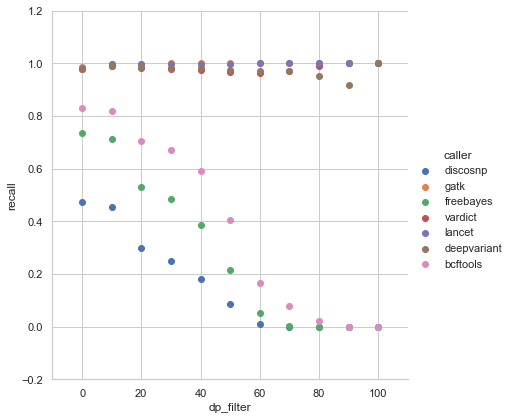

In [42]:
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=testh37rv1000ind_summary, hue='caller', height=6, aspect=1, xlim=(-10,110), ylim=(-0.2,1.2))
fg.map(plt.scatter, 'dp_filter', 'recall').add_legend()

### Deletions and Insertions (Duplications, Random, Inversions)
#### H37Rv10-3IND1

- DEL: 2116
- INS: 2201 (1119 DUP + 524 RDM + 558 INV)

In [4]:
h37rv1000ind1 = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv10-3IND1_alltools_normalized_dp0_checked.csv')

In [21]:
# Filtered on BAM_DP
h37rv1000ind1_summary = combine_filtered(h37rv1000ind1, 'BAM_DP', 0, 100, 10, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3IND1.log')

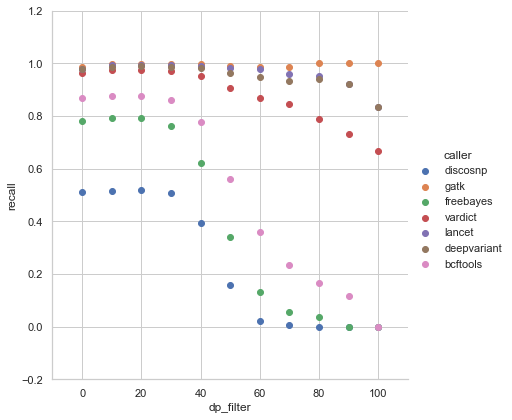

In [43]:
%matplotlib inline
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=h37rv1000ind1_summary, hue='caller', height=6, aspect=1, xlim=(-10,110), ylim=(-0.2,1.2))
fg.map(plt.scatter, 'dp_filter', 'recall').add_legend()

### Deletions and Insertions (Random and Inversions only)
#### H37Rv10-3IND-NODUP

- DEL: 2173
- INS: 2101 (0 DUP + 1040 RDM + 1061 INV)

In [23]:
h37rv1000ind_nodup = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv10-3IND-NODUP_alltools_normalized_dp0_checked.csv')

In [24]:
# Filtered on BAM_DP
h37rv1000ind_nodup_summary = combine_filtered(h37rv1000ind_nodup, 'BAM_DP', 0, 100, 10, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3IND-NODUP.log')

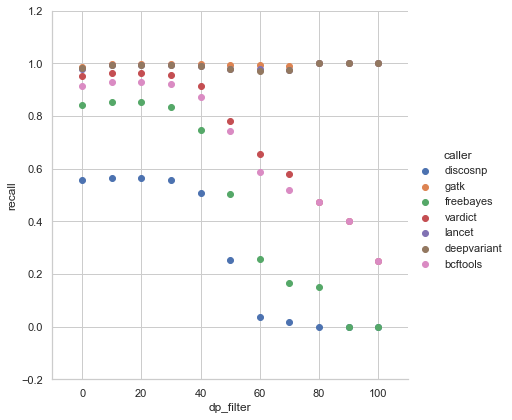

In [44]:
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=h37rv1000ind_nodup_summary, hue='caller', height=6, aspect=1, xlim=(-10,110), ylim=(-0.2,1.2))
fg.map(plt.scatter, 'dp_filter', 'recall').add_legend()

### Deletions only
#### H37Rv10-3DEL

- DEL: 4285
- INS: 0

In [29]:
h37rv1000del = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv10-3DEL_alltools_normalized_dp0_checked.csv')

In [40]:
# Filtered on BAM_DP
h37rv1000del_summary = combine_filtered(h37rv1000del, 'BAM_DP', 0, 80, 10, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3DEL.log')

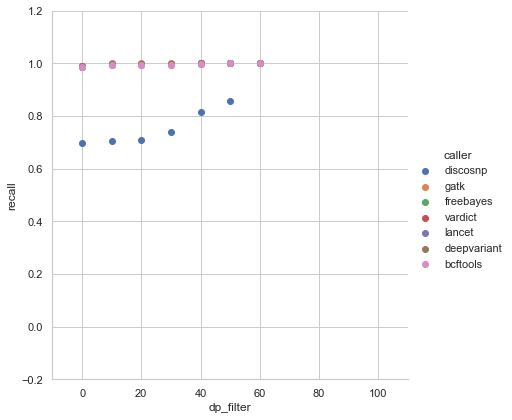

In [45]:
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=h37rv1000del_summary, hue='caller', height=6, aspect=1, xlim=(-10,110), ylim=(-0.2,1.2))
fg.map(plt.scatter, 'dp_filter', 'recall').add_legend()

In [48]:
sum_filtered(h37rv1000del, 'BAM_DP', 40, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3DEL.log')

,caller,true_pos,false_pos,false_neg,dp_filter,recall,precision,total_mut_intro,total_mut_postfilter
0,discosnp,817,2,187,40,0.813745,0.997558,4285,1004
1,gatk,1004,0,0,40,1.000000,1.000000,4285,1004
2,freebayes,1002,0,2,40,0.998008,1.000000,4285,1004
3,vardict,1004,0,0,40,1.000000,1.000000,4285,1004
4,lancet,1004,6189,0,40,1.000000,0.139580,4285,1004
5,deepvariant,1004,0,0,40,1.000000,1.000000,4285,1004
6,bcftools,1001,1,3,40,0.997012,0.999002,4285,1004


### Insertions only
#### H37Rv10-3INS

- DEL: 0
- INS: TBD

In [29]:
h37rv1000ins = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv10-3INS_alltools_normalized_dp0_checked.csv')

In [40]:
# Filtered on BAM_DP
h37rv1000ins_summary = combine_filtered(h37rv1000ins, 'BAM_DP', 0, 100, 10, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3INS.log')

In [49]:
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=h37rv1000ins_summary, hue='caller', height=6, aspect=1, xlim=(-10,110), ylim=(-0.2,1.2))
fg.map(plt.scatter, 'dp_filter', 'recall').add_legend()

NameError: name 'h37rv1000ins_summary' is not defined